In [434]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO, autoguide, Predictive
from pyro.optim import Adam, ClippedAdam
import torch

In [376]:
df_weather = pd.read_csv('./data/2023_Weather.csv')
df_weather.drop(columns=['Unnamed: 0'], inplace=True)
df_weather.dropna(inplace=True)
df_weather.rename(columns={'Time': 'datetime'}, inplace=True)
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather.set_index('datetime', inplace=True)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8759 entries, 2023-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   acc_precip         8759 non-null   float64
 1   mean_temp          8759 non-null   float64
 2   mean_relative_hum  8759 non-null   float64
 3   mean_wind_speed    8759 non-null   float64
 4   mean_radiation     8759 non-null   float64
dtypes: float64(5)
memory usage: 410.6 KB


In [377]:
# Read and parse
df_acc = pd.read_csv('./data/2022-2024-accident-data.csv', sep=';', dtype=str, encoding='latin1')
df_acc['X'] = df_acc['X_KOORDINAT'].str.replace(',', '.').astype(float)
df_acc['Y'] = df_acc['Y_KOORDINAT'].str.replace(',', '.').astype(float)
df_acc['datetime'] = pd.to_datetime(df_acc['UHELDSDATO'] + ' ' + df_acc['TIME'] + ':00', format='mixed') # %d.%m.%Y %H:%M

In [378]:
# Filter data
cols = ['X', 'Y', 'datetime']

df_acc = df_acc[cols]
df_acc = df_acc[(df_acc['datetime'] > '2023-01-01') & (df_acc['datetime'] < '2024-01-01')]
df_acc.sort_values(by='datetime', inplace=True)
df_acc.set_index('datetime', inplace=True)
df_acc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2071 entries, 2023-01-01 01:00:00 to 2023-12-31 20:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       2071 non-null   float64
 1   Y       2071 non-null   float64
dtypes: float64(2)
memory usage: 48.5 KB


In [379]:
df_acc

,X,Y
datetime,,
2023-01-01 01:00:00,722486.694,6174248.234
2023-01-01 06:00:00,723849.001,6179181.001
2023-01-01 15:00:00,724281.001,6180047.001
2023-01-02 07:00:00,725480.428,6175703.304
2023-01-02 07:00:00,725696.001,6172194.001
...,...,...
2023-12-31 11:00:00,725767.621,6175295.080
2023-12-31 14:00:00,721999.001,6174749.001
2023-12-31 14:00:00,727656.001,6174998.001


In [380]:
# Calculate grid
CELL_SIZE = 500

# Compute origin
minx, miny = df_acc['X'].min(), df_acc['Y'].min()

# Compute bin indices with floor
df_acc['ix'] = np.floor((df_acc['X'] - minx) // CELL_SIZE).astype(int)
df_acc['iy'] = np.floor((df_acc['Y'] - miny) // CELL_SIZE).astype(int)
    
# First, calculate the center coordinates for each cell
df_acc['center_x'] = minx + (df_acc['ix'] + 0.5) * CELL_SIZE
df_acc['center_y'] = miny + (df_acc['iy'] + 0.5) * CELL_SIZE

df_acc['cell_id'] = list(zip(df_acc['center_x'], 
                        df_acc['center_y']))

# Now groupby with the calculated centers
df_acc_centers = df_acc.groupby(['cell_id', 'datetime']).agg({
    'X': 'first',
    'Y': 'first'
})#.size().rename('acc_count')

df_acc_centers['acc_count'] = df_acc.groupby(['cell_id', 'datetime']).size()

In [391]:
unique_cells = df_acc_centers.index.get_level_values('cell_id').unique()
hours  = df_weather.index
idx = pd.MultiIndex.from_product([unique_cells, hours],
                                names=['cell_id', 'datetime'])

df = pd.DataFrame(index=idx)


In [393]:
# put the counts in and turn NaN → 0
df = df.join(df_acc_centers['acc_count']).fillna({'acc_count': 0}).astype({'acc_count': int})

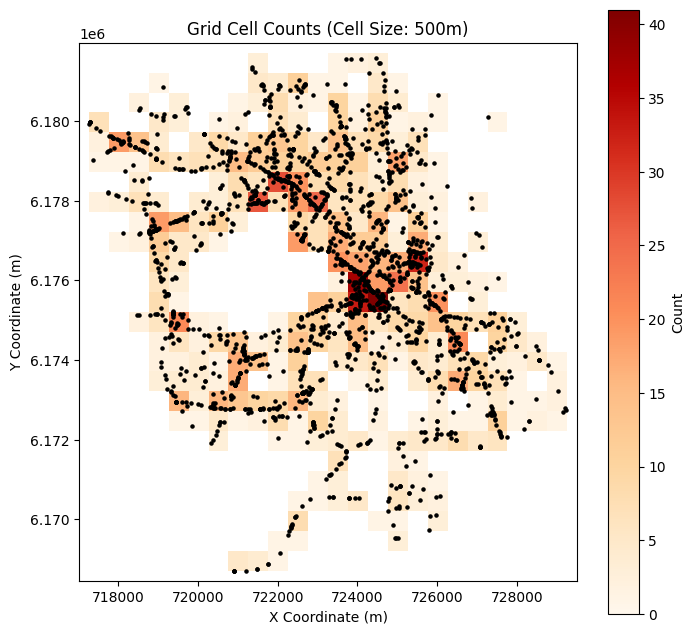

In [413]:
def plot_grid_counts(cell_centers, accidents=None):
    """
    Draws a coloured grid and overlays the accidents.
    :param cell_centers: series with the center coordinates of each cell as index, and with the accident counts per cell
    :param accidents: tuple with the coordinates of each accident
    """
    vmax = cell_centers.max()
    fig, ax = plt.subplots(figsize=(7,7))

    

    # draw each occupied cell
    for center_coords, count in cell_centers.items():
        # Extract center coordinates
        center_x, center_y = center_coords
        
        # Calculate top-left corner of the cell
        x0 = center_x - CELL_SIZE/2
        y0 = center_y - CELL_SIZE/2

        rect = plt.Rectangle(
            (x0, y0),
            CELL_SIZE, CELL_SIZE,
            facecolor=plt.cm.OrRd(count/vmax),
            edgecolor='grey', linewidth=0
        )
        ax.add_patch(rect)

    # Optional: scatter accident points if provided
    if accidents is not None:
        x = accidents[0]
        y = accidents[1]
        ax.scatter(x=x, y=y, s=5, c='black')    

    # Set plot properties
    ax.set_aspect('equal')
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.title(f'Grid Cell Counts (Cell Size: {CELL_SIZE}m)')
    
    # Set reasonable axis limits based on the data
    all_x = [x for x, y in cell_centers.index]
    all_y = [y for x, y in cell_centers.index]
    x_min, x_max = min(all_x) - CELL_SIZE, max(all_x) + CELL_SIZE
    y_min, y_max = min(all_y) - CELL_SIZE, max(all_y) + CELL_SIZE
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.colorbar(plt.cm.ScalarMappable(cmap="OrRd", 
                                       norm=plt.Normalize(0, vmax)), 
                 ax=ax, label="Count")
    plt.show()

cell_centers = df[df['acc_count'] != 0].index.get_level_values('cell_id').value_counts()
accidents = (df_acc_centers['X'].tolist(), df_acc_centers['Y'].tolist())
plot_grid_counts(cell_centers, accidents)

In [410]:
df

acc_count
cell_id                   datetime                      
(717514.445, 6177963.565) 2023-01-01 00:00:00          0
                          2023-01-01 01:00:00          0
                          2023-01-01 02:00:00          0
                          2023-01-01 03:00:00          0
                          2023-01-01 04:00:00          0
...                                                  ...
(729014.445, 6173963.565) 2023-12-31 19:00:00          0
                          2023-12-31 20:00:00          0
                          2023-12-31 21:00:00          0
                          2023-12-31 22:00:00          0
                          2023-12-31 23:00:00          0

[2697772 rows x 1 columns]

In [418]:
df['acc_count']

cell_id                    datetime           
(717514.445, 6177963.565)  2023-01-01 00:00:00    0
                           2023-01-01 01:00:00    0
                           2023-01-01 02:00:00    0
                           2023-01-01 03:00:00    0
                           2023-01-01 04:00:00    0
                                                 ..
(729014.445, 6173963.565)  2023-12-31 19:00:00    0
                           2023-12-31 20:00:00    0
                           2023-12-31 21:00:00    0
                           2023-12-31 22:00:00    0
                           2023-12-31 23:00:00    0
Name: acc_count, Length: 2697772, dtype: int64

In [439]:
import pyro
import pyro.distributions as dist

# 1) extract per-row raw values
raw_cells = df.index.get_level_values('cell_id')        # length N_obs
raw_times = df.index.get_level_values('datetime')       # length N_obs

y          = torch.tensor(df['acc_count'].values, dtype=torch.float)

# 2) map cells
unique_cells   = df.index.get_level_values('cell_id').unique().tolist()
cell_map      = {c:i for i,c in enumerate(unique_cells)}

# 3) encode each row as an integer 0…N_cells−1
cell_codes = raw_cells.map(cell_map).to_numpy(dtype=int)  # length N_obs
cell_idx   = torch.tensor(cell_codes, dtype=torch.long)

# 4) encode hour-of-day per row
hour_codes = raw_times.hour.to_numpy(dtype=int)           # 0…23, length N_obs
hour_idx   = torch.tensor(hour_codes, dtype=torch.long)

N_cells = len(unique_cells)
N_hours = 24
N_obs   = y.shape[0]

# 3) DEFINE the Pyro model
def baseline_model(cell_idx, hour_idx, y=None):
    # hyper-priors on random-effect scales
    sigma_u = pyro.sample("sigma_u", dist.HalfCauchy(5.))
    sigma_v = pyro.sample("sigma_v", dist.HalfCauchy(5.))
    
    # global intercept
    alpha   = pyro.sample("alpha", dist.Normal(0., 5.))

    # spatial random effects u_i ~ Normal(0, σ_u)
    with pyro.plate("cells", N_cells):
        u = pyro.sample("u", dist.Normal(0., sigma_u))
        
    # temporal random effects v_h ~ Normal(0, σ_v)
    with pyro.plate("hours", N_hours):
        v = pyro.sample("v", dist.Normal(0., sigma_v))

    # obs-plate (vectorized)
    with pyro.plate("data", N_obs):
        n = alpha + u[cell_idx] + v[hour_idx]
        λ = torch.exp(n)
        #print("  ▶️  n.shape =", n.shape,  "  λ.shape =", λ.shape,  "  y.shape =", y.shape)
        pyro.sample("obs", dist.Poisson(λ), obs=y)


# 1) Poisson‐count model
def poisson_model(counts, num_cells):
    # Priors over regression coefficients
    beta0       = pyro.sample("beta0",       dist.Normal(0., 10.))
    beta_precip = pyro.sample("beta_precip", dist.Normal(0., 10.))
    # Latent precipitation for each cell
    precip = pyro.sample(
        "precip", 
        dist.Normal(0., 1.)
            .expand([num_cells])
            .to_event(1)
    )
    with pyro.plate("cells", num_cells):
        # log‐link: λ_i = exp(β0 + β_precip * precip_i)
        rate = torch.exp(beta0 + beta_precip * precip)
        pyro.sample("obs_counts", dist.Poisson(rate), obs=counts)


# 2) Bernoulli‐presence model
def bernoulli_model(presence, num_cells):
    # Priors over regression coefficients
    alpha0       = pyro.sample("alpha0",       dist.Normal(0., 10.))
    alpha_precip = pyro.sample("alpha_precip", dist.Normal(0., 10.))
    # Same latent precipitation
    precip = pyro.sample(
        "precip", 
        dist.Normal(0., 1.)
            .expand([num_cells])
            .to_event(1)
    )
    with pyro.plate("cells", num_cells):
        # logit‐link: logit(p_i) = α0 + α_precip * precip_i
        logits = alpha0 + alpha_precip * precip
        pyro.sample("obs_presence", dist.Bernoulli(logits=logits), obs=presence)

In [ ]:
# 4) SET UP SVI with an automatic guide
guide = autoguide.AutoNormal(baseline_model)
optim = Adam({"lr": 1e-2})
svi   = SVI(baseline_model, guide, optim, loss=Trace_ELBO())

# 5) FIT via SVI
num_steps = 2000
for step in range(num_steps):
    loss = svi.step(cell_idx, hour_idx, y)
    if step % 200 == 0:
        print(f"[{step:4d}] loss = {loss:.1f}")

[   0] loss = 17643.4
[ 200] loss = 16593.9


In [438]:
# Prediction...

# 1) pick a cell to visualize
cells = df.index.get_level_values('cell_id').unique().tolist()
sample_cell = cells[0]           # or any cell string you like

# 2) build the per-hour index & codes for that cell
all_hours = pd.date_range("2023-01-01", "2023-12-31 23:00", freq="H")
sub = (
    df.xs(sample_cell, level="cell_id")      # DataFrame indexed by datetime
      .reindex(all_hours, fill_value=0)
      .rename_axis("datetime")
      .rename(columns={"acc_count": "y"})
)
y_obs      = torch.tensor(sub["y"].values, dtype=torch.float)
hour_codes = torch.tensor(sub.index.hour.values, dtype=torch.long)
# we’ll pass `cell_idx` as zeros since we’re always in the same cell:
cell_idx   = torch.zeros_like(hour_codes)

# 3) posterior-predictive sampling
predictive = Predictive(
    baseline_model,
    guide=guide,
    num_samples=300,
    return_sites=["obs"]
)
samples = predictive(cell_idx, hour_codes)["obs"]    # shape [300, len(all_hours)]

# 4) compute the posterior mean prediction
y_pred_mean = samples.float().mean(0).numpy()

# 5) plot Observed vs Predicted
plt.figure(figsize=(12, 4))
plt.plot(sub.index, sub["y"],      label="Observed", linewidth=1)
plt.plot(sub.index, y_pred_mean,   label="Predicted mean", linewidth=1)
plt.xlabel("Datetime")
plt.ylabel("Accident count")
plt.title(f"Accidents in cell {sample_cell} (observed vs. posterior mean)")
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_9/1665991198.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_hours = pd.date_range("2023-01-01", "2023-12-31 23:00", freq="H")


AttributeError: 'NoneType' object has no attribute 'shape'

### Previous attempt

In [43]:
# Clear any old parameters
pyro.clear_param_store()

# Guide: mean‐field normal over all latent RVs in poisson_model
poisson_guide = autoguide.AutoNormal(poisson_model)

# SVI object
poisson_svi = SVI(model=poisson_model,
                  guide=poisson_guide,
                  optim=Adam({"lr": 0.02}),
                  loss=Trace_ELBO())

# Training loop
num_iters = 2000
for i in range(num_iters):
    loss = poisson_svi.step(counts, num_cells)
    if i % 200 == 0:
        print(f"[Poisson] Iter {i:>4} \tELBO = {-loss:.1f}")


[Poisson] Iter    0 	ELBO = -15216.9
[Poisson] Iter  200 	ELBO = -1934.6
[Poisson] Iter  400 	ELBO = -1888.6
[Poisson] Iter  600 	ELBO = -1856.9
[Poisson] Iter  800 	ELBO = -1837.0
[Poisson] Iter 1000 	ELBO = -1831.1
[Poisson] Iter 1200 	ELBO = -1836.4
[Poisson] Iter 1400 	ELBO = -1845.4
[Poisson] Iter 1600 	ELBO = -1838.8
[Poisson] Iter 1800 	ELBO = -1837.5


In [38]:
poisson_guide.median().items()

dict_items([('beta0', tensor(-0.8050)), ('beta_precip', tensor(0.1260)), ('precip', tensor([0.0264]))])

In [44]:
# After training: get posterior summaries
poisson_posterior = {name: torch.exp(site).item()
                     if name=="beta0" else site.item()
                     for name, site in poisson_guide.median().items()}
print("Poisson posteriors:", poisson_posterior)

RuntimeError: a Tensor with 513 elements cannot be converted to Scalar